<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_Forecasting_L63_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for short-term forecasting using recurrent neural networks and physics-informed networks **: Application to the short-term forecasting of Lorenz-63 dynamics.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition

from scipy.integrate import odeint


In [ ]:
!pip install torchviz
import torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=9b85b9220f2884029da8621746e5dd5a0a5096f6626eb343e63ef13fa8aec4f8
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# **L63 Data simulation**: simulate L63 time series from the known ODE

In [ ]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = np.zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx


# Define the parameters
x0 = np.array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 200 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, np.arange(0.01,T,dt), args=(sigma,rho,beta))  
time = np.arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()

torch.Size([19999, 3])


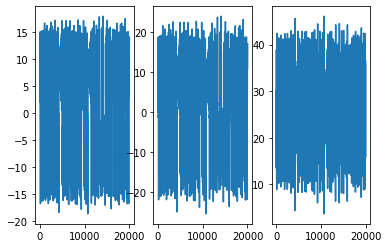

In [ ]:
print(x.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(x[:,jj])

In [ ]:
from sklearn.feature_extraction import image

####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 30
  
# extract subsequences
X_train = image.extract_patches_2d(x[3000:15000:time_step,:],(dT,3),max_patches=NbTraining)
X_test  = image.extract_patches_2d(x[17500::time_step,:],(dT,3),max_patches=NbTest)

X_train      = np.moveaxis(X_train,-1,1)
X_test      = np.moveaxis(X_test,-1,1)


############################################
## normalized data
meanTr          = np.mean(X_train[:]) 
stdTr           = np.std( X_train[:] )

# scale wrt std
x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))
print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


.... MeanTr = 8.299 --- StdTr = 13.808 
..... Training dataset: 10000x3x30
..... Test dataset    : 2000x3x30


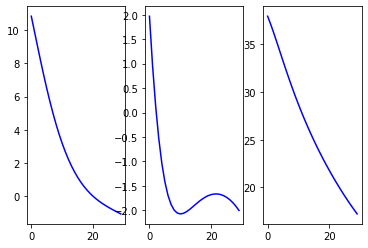

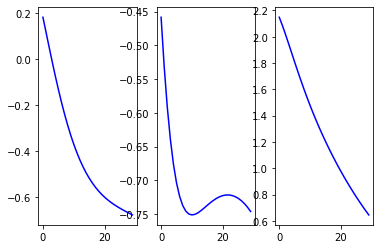

In [ ]:
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')

plt.figure(2)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(x_train[20,jj,:],'b-')

# **Forecasting model definition**: choose yor model (linear AR model), residual MLP, GRU, LSTM, ODE-based parameterization. ** TO DO**: (1) code the LSTM version, (2) repalce the Euler-like residual upadte by a Runge-Kutta integration scheme  

In [1]:
flag_model = 3

if flag_model == 0 :

  ## linear forecasting model
  class linear_regression_nn(torch.nn.Module):
    
    # class initialization
    def __init__(self, input_size, output_size):
        super(linear_regression_nn, self).__init__()
        # fully connected layer with linear activation
        self.fc = torch.nn.Linear(input_size, output_size)
        
    # function to apply the neural network
    def forward(self, x_in, n_step=1):
      x = x_in

      for nn in range(0,n_step):
        x = self.fc(x)

        if nn > 0 :
          x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
        else:
          x_out = x.view(-1,3,1)

      return x_out

  forecast_model = linear_regression_nn(3, 3)

elif flag_model == 1 :

  ## MLP architecture (relu)
  class mlp_regression_nn(torch.nn.Module):
    
    # class initialization
    def __init__(self, input_size, output_size):
        super(mlp_regression_nn, self).__init__()
        # fully connected layer with linear activation
        self.fc1 = torch.nn.Linear(input_size, 20)
        self.fc2 = torch.nn.Linear(20, output_size)
        
    # function to apply the neural network
    def _f(self,x):
      return self.fc2( torch.relu( self.fc1(x) ) )

    def _EulerSolver(self, x):
        return x + self.dt * self._f(x)

    def _RK4Solver(self, x):
        k1 = self._f(x)
        x2 = x + 0.5 * self.dt * k1
        k2 = self._f(x2)
      
        x3 = x + 0.5 * self.dt * k2
        k3 = self._f(x3)
          
        x4 = x + self.dt * k3
        k4 = self._f(x4)

        return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.

    def _ode_solver(self,x):
        if self.solver == 'euler' :
          return self._EulerSolver(x)
        else:
          return self._RK4Solver(x)

    def forward(self, x_in, n_step=1):
      x = x_in

      for nn in range(0,n_step):
        dx = self._f(x)

        x = x + dx
        if nn > 0 :
          x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
        else:
          x_out = x.view(-1,3,1)

      return x_out

  forecast_model = mlp_regression_nn(3, 3)
  best_forecast_model = mlp_regression_nn(3, 3)

elif flag_model == 2 :

  ## Lorenz parameterization
  class lorenz_nn(torch.nn.Module):    
    # class initialization
    def __init__(self,sigma,rho,beta,dt):
        super(lorenz_nn, self).__init__()

        self.sigma = torch.nn.Parameter(torch.Tensor([sigma]), requires_grad=True)
        self.rho   = torch.nn.Parameter(torch.Tensor([rho]), requires_grad=True)
        self.beta  = torch.nn.Parameter(torch.Tensor([beta]), requires_grad=True)
        self.dt = dt

    # function to apply the neural network
    def _f(self,x):
      x = x * stdTr + meanTr

      x_1 = (self.sigma*(x[:,1]-x[:,0])).view(-1,1)
      x_2 = (x[:,0]*(self.rho-x[:,2])-x[:,1]).view(-1,1)
      x_3 = (x[:,0]*x[:,1] - self.beta*x[:,2]).view(-1,1)

      x_out = torch.cat((x_1,x_2,x_3),dim=1)

      x_out = (x_out - meanTr) / stdTr
      return x_out

    def forward(self, x_in, n_step=1):
      x = x_in

      for nn in range(0,n_step):
        dx = self._f(x)

        x = x + self.dt * dx
        if nn > 0 :
          x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
        else:
          x_out = x.view(-1,3,1)

      return x_out

  forecast_model = lorenz_nn(0.8*sigma,0.9*rho,1.2*beta,dt)
  best_forecast_model = lorenz_nn(0.8*sigma,0.9*rho,1.2*beta,dt)

elif flag_model == 3 :

  # LSTM-based forecasting
  class LSTM_nn(torch.nn.Module):    
    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_nn, self).__init__()

        # TO DO
    # function to apply the neural network
    def _f(self,x, h ):
        # TO DO

        return y_pred, (h_out, c_out)

    def forward(self, x_in, n_step=1):
      # TO DO


      return x_out

  forecast_model = LSTM_nn(3, 10, 3 )
  best_forecast_model = LSTM_nn(3, 10, 3 )

elif flag_model == 4 :

  # GRU-based forecasting
  class GRU_nn(torch.nn.Module):    
    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_nn, self).__init__()
        # LSTM layer with 1 hidden layer (hidden_size neurons inside)
        self.gru = torch.nn.GRUCell(input_size, hidden_size)
        
        # fully connected layer with linear activation
        self.fc = torch.nn.Linear(hidden_size, output_size)

        self.hidden_size = hidden_size
    # function to apply the neural network
    def _f(self,x, h ):
        h_out = self.gru(x,h)
        y_pred = self.fc(h_out)
        
        return y_pred, h_out

    def forward(self, x_in, n_step=1):
      x = x_in
      h = torch.randn(x_in.size(0), self.hidden_size) # (batch, hidden_size)

      for nn in range(0,n_step):
        x, h = self._f(x, h )

        if nn > 0 :
          x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
        else:
          x_out = x.view(-1,3,1)

      return x_out

  forecast_model = GRU_nn(3, 10, 3 )
  best_forecast_model = GRU_nn(3, 10, 3 )


NameError: ignored

# Model training

In [ ]:
batch_size = 32

indperm = np.random.permutation( x_train.shape[0])
m = int(0.75 * x_train.shape[0])

dataloaders = {
    'train': torch.utils.data.DataLoader(x_train[indperm[0:m],:,:], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(x_train[indperm[m:],:,:], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def compute_loss(model,batch,n_step_forecast,phase):
  x = batch[:,:,0]

  with torch.set_grad_enabled(True): 
    x_out = model(x,n_step=n_step_forecast)
    
    # compute and stock the loss
    loss = 1e3 * torch.mean( (x_out - batch[:,:,1:n_step_forecast+1])**2 )

  return loss,x_out

def train_epoch(model,data,n_step_forecast):

  loss_epoch = 0.

  for batch in data:
    loss,out = compute_loss(model,batch,n_step_forecast,phase='train')

    # initialize the gradient to zero
    optimizer.zero_grad()
    
    # compute the gradient by back propagation
    loss.backward()
  
    # update the parameter values using the gradient
    optimizer.step()

    loss_epoch += loss.detach()

  return loss_epoch.detach(),out

def test_epoch(model,data,n_step_forecast):

  loss_epoch=0.

  out_all = None 
  for batch in data:
    loss,out = compute_loss(model,batch,n_step_forecast,phase='test')
    
    # compute the gradient by back propagation
    loss_epoch += loss
  
    if out_all is not None :
        out_all = np.concatenate((out_all,out.detach().cpu().numpy()),axis=0)
    else:
        out_all = out.detach().cpu().numpy()

  return loss_epoch.detach(),out_all


In [ ]:
# Loss function: MSE = sum [(y - y_pred)^2]
criterion = torch.nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.Adam(forecast_model.parameters(), lr=1e-3)

In [ ]:
epochs = 40 # number of epochs
losses = [] # list to stock the loss at each iteration

n_step_forecast = 2
h,c = None, None

# Loop on epochs
loss_train=[]
loss_val=[]
loss_test=[]
valid_loss_min = 1e10

for i in range(epochs):
    
    # compute the prediction using the previous parameters of the neural network
    loss_train_epoch,out = train_epoch( forecast_model, dataloaders['train'] , n_step_forecast )

    loss_val_epoch,out = test_epoch( forecast_model , dataloaders['val'] , n_step_forecast )

    loss_test_epoch,out = test_epoch( forecast_model , dataloaders['test'] , n_step_forecast )
    
    loss_train.append(loss_train_epoch)
    loss_val.append(loss_val_epoch)
    loss_test.append(loss_test_epoch)

    if loss_val_epoch <= valid_loss_min:
        print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        loss_val_epoch))
        torch.save(forecast_model.state_dict(), 'forecast_model.pt')
        valid_loss_min = loss_val_epoch


    print('Epoch ' + str(i) + '/' + str(epochs) + ' - ' + 'Loss ' + str(loss_train_epoch.detach().cpu().numpy())+ '  -- ' + str(loss_val_epoch.detach().cpu().numpy())+ '  -- ' + str(loss_test_epoch.detach().cpu().numpy()))

validation loss decreased (10000000000.000000 --> 22949.228516).  Saving model ...
Epoch 0/40 - Loss 134502.8  -- 22949.229  -- 18519.168
validation loss decreased (22949.228516 --> 9009.184570).  Saving model ...
Epoch 1/40 - Loss 42870.59  -- 9009.185  -- 7651.542
validation loss decreased (9009.184570 --> 4354.136230).  Saving model ...
Epoch 2/40 - Loss 18920.465  -- 4354.136  -- 3595.8616
validation loss decreased (4354.136230 --> 2827.056152).  Saving model ...
Epoch 3/40 - Loss 10027.778  -- 2827.0562  -- 2314.9146
validation loss decreased (2827.056152 --> 2073.589600).  Saving model ...
Epoch 4/40 - Loss 7036.099  -- 2073.5896  -- 1686.1439
validation loss decreased (2073.589600 --> 1571.901123).  Saving model ...
Epoch 5/40 - Loss 5208.5293  -- 1571.9011  -- 1317.4462
validation loss decreased (1571.901123 --> 1179.288940).  Saving model ...
Epoch 6/40 - Loss 3960.9902  -- 1179.289  -- 975.3882
validation loss decreased (1179.288940 --> 850.926086).  Saving model ...
Epoch 7/

Text(0, 0.5, 'Loss value')

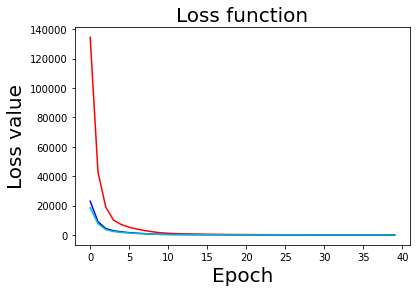

In [ ]:
# Print the loss function
plt.plot(loss_train,'r-')
plt.plot(loss_val,'b-')
plt.plot(loss_test,'c-')
plt.title('Loss function', size=20)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss value', size=20)

# Model testing

In [ ]:
# reload best model
best_forecast_model.load_state_dict(torch.load('forecast_model.pt'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


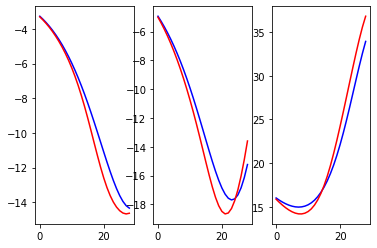

In [ ]:
# test model for the considered time window
loss_test_epoch, out = test_epoch(best_forecast_model, dataloaders['test'] , 29 )
out = out * stdTr + meanTr


mse = np.sum( np.sum( (X_test - out)**2 , dim = 0 ) , dim=1 )
var = np.sum( np.sum( (X_test[:,:,0] - X_test[:,:,1:] )**2 ))


idx = 80
plt.figure(1)
for ii in range(3):
  plt.subplot(1,3,ii+1)
  plt.plot(X_test[idx,ii,1:],'b')
  plt.plot(out[idx,ii,:],'r')


In [ ]:
mse = np.sum( np.sum( (X_test[:,:,1:] - out)**2 , axis = 0 ) , axis=0 )
var = np.sum( np.sum( ( np.tile(X_test[:,:,0].reshape(-1,3,1),(1,1,X_test.shape[2]-1)) - X_test[:,:,1:] )**2 , axis = 0 ) , axis= 0 )

var *= 1./(X_test.shape[0]*3 )
mse *= 1./(X_test.shape[0]*3 )

var_exp = 1. - mse / var

print('............................ ')
print('... Explained variance')
for _k in range(0,X_test.shape[2]-1):
  print('... dt = %d : %f '%(_k+1,var_exp[_k]))

............................ 
... Explained variance
... dt = 1 : 0.950484 
... dt = 2 : 0.972349 
... dt = 3 : 0.978031 
... dt = 4 : 0.980995 
... dt = 5 : 0.982893 
... dt = 6 : 0.984186 
... dt = 7 : 0.985081 
... dt = 8 : 0.985700 
... dt = 9 : 0.986125 
... dt = 10 : 0.986411 
... dt = 11 : 0.986583 
... dt = 12 : 0.986648 
... dt = 13 : 0.986601 
... dt = 14 : 0.986437 
... dt = 15 : 0.986162 
... dt = 16 : 0.985787 
... dt = 17 : 0.985323 
... dt = 18 : 0.984776 
... dt = 19 : 0.984144 
... dt = 20 : 0.983422 
... dt = 21 : 0.982601 
... dt = 22 : 0.981674 
... dt = 23 : 0.980635 
... dt = 24 : 0.979478 
... dt = 25 : 0.978203 
... dt = 26 : 0.976810 
... dt = 27 : 0.975296 
... dt = 28 : 0.973650 
... dt = 29 : 0.971848 


# Application to long-term simulation

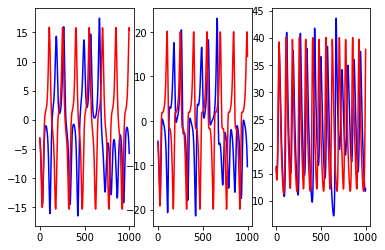

In [ ]:
# simulation over a larger time window
Nstep = 1000#30000
X0 = torch.Tensor(X_test[idx,:,0]).view(1,3)

# simulation with trained model
x0 = (X0 - meanTr) / stdTr
X_out = forecast_model(x0,n_step=Nstep)
X_out = X_out.detach() * stdTr + meanTr
X_out = X_out.squeeze()

# simulation with true OODE
X0 = X_test[idx,:,0]
X_ode = odeint(Lorenz_63, X0, np.arange(0.01,Nstep*dt,dt), args=(sigma,rho,beta))

plt.figure(1)
for ii in range(3):
  plt.subplot(1,3,ii+1)
  plt.plot(X_ode[Nstep-1000:Nstep,ii],'b')
  plt.plot(X_out[ii,Nstep-1000:Nstep],'r')


Text(0.5, 0.92, 'Prediction of Lorenz-63 trajectories')

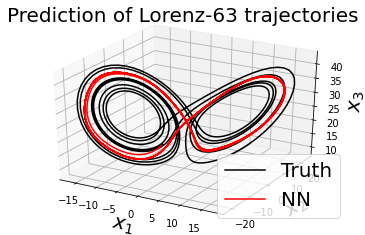

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
line1, = ax.plot(X_ode[:,0], X_ode[:,1], X_ode[:,2], 'k')
line2, = ax.plot(X_out[0,:].detach().numpy(), X_out[1,:].detach().numpy(), X_out[2,:].detach().numpy(), 'r')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
plt.legend([line1, line2], ['Truth','NN'], fontsize=20)
plt.title('Prediction of Lorenz-63 trajectories', size=20)